# LSTM part-of-speech tagging and supertagging for the French Treebank: 

This notebook trains a part-of-speech tagger and supertagger for the French Treebank using a vanilla bi-direction LSTM network.

Run the following cell to load the Keras packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

from keras.models import Model, load_model
from keras.layers import Bidirectional, Masking, Dense, Input, Dropout, LSTM, Activation, TimeDistributed, BatchNormalization, concatenate, Concatenate
from keras.layers.embeddings import Embedding
from keras.constraints import max_norm
from keras import regularizers
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from keras import backend as K
from sklearn.model_selection import train_test_split

from grail_data_utils import *

%matplotlib inline

np.random.seed(1)

Using TensorFlow backend.


### Read the TLGbank file

In [2]:
# very small initial part of corpus (only file aa1)
# X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('aa1.txt')

In [2]:
# small initial part of corpus (files aa1, aa2, ab2 and ae1)
# number of sentences, train: 1195, test: 398, dev: 399  
X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('aa1_ae1.txt')

In [4]:
# entire corpus
# number of sentences, train: 9449, test: 3150, dev: 3150
X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('m2.txt')

## 2. Create auxiliary mappings

Create mappings from supertags and the two sets of part-of-speech tags to integers and back.

In [2]:
import pickle

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

super_to_index = load_obj('super_to_index')
index_to_super = load_obj('index_to_super')
pos1_to_index = load_obj('pos1_to_index')
index_to_pos1 = load_obj('index_to_pos1')
pos2_to_index = load_obj('pos2_to_index')
index_to_pos2 = load_obj('index_to_pos2')


In [4]:
# create mapping for the two POS tagset and for the supertags

# super_to_index, index_to_super = indexify(superset)
# pos1_to_index, index_to_pos1 = indexify(partsofspeech1)
# pos2_to_index, index_to_pos2 = indexify(partsofspeech2)
print(pos1_to_index)
print(pos2_to_index)

{'CS': 1, 'PROWH': 2, 'NPP': 3, 'DETWH': 4, 'PREF': 5, 'P+D': 6, 'PONCT': 7, 'P': 8, 'CLR': 9, 'PRO': 10, 'P+PRO': 11, 'ADVWH': 12, 'NC': 13, 'VIMP': 14, 'CLO': 15, 'V': 16, 'VINF': 17, 'VPR': 18, 'ET': 19, 'CLS': 20, 'CC': 21, 'I': 22, 'DET': 23, 'VPP': 24, 'PROREL': 25, 'ADJ': 26, 'VS': 27, 'ADV': 28, 'ADJWH': 29}
{'PRP': 1, 'VER:simp': 2, 'VER:impf': 3, 'NOM': 4, 'PUN': 5, 'PRO:IND': 6, 'PRO:DEM': 7, 'PRO:POS': 8, 'KON': 9, 'DET:ART': 10, 'ADV': 11, 'PUN:cit': 12, 'PRO:PER': 13, 'VER:pres': 14, 'PRO': 15, 'NUM': 16, 'VER:infi': 17, 'VER:futu': 18, 'VER:cond': 19, 'VER:subp': 20, 'PRP:det': 21, 'NAM': 22, 'INT': 23, 'PRO:REL': 24, 'VER:ppre': 25, 'ABR': 26, 'SYM': 27, 'ADJ': 28, 'DET:POS': 29, 'VER:pper': 30, 'VER:impe': 31}


In [4]:
maxLen = 266

In [5]:
numPos1Classes = len(index_to_pos1) + 1
numPos2Classes = len(index_to_pos2) + 1
numSuperClasses = len(index_to_super)+1

print()
print("Longest sentence   : ", maxLen)
print("Number of POS1 tags: ", numPos1Classes)
print("Number of POS2 tags: ", numPos2Classes)
print("Number of supertags: ", numSuperClasses)




Longest sentence   :  266
Number of POS1 tags:  30
Number of POS2 tags:  32
Number of supertags:  891


## 3 Compute ELMo embedding for the sentences in the corpus

Load the French ELMo embeddings from [elmoformanylangs](https://github.com/HIT-SCIR/ELMoForManyLangs).

In [6]:
from elmoformanylangs import Embedder

e = Embedder('/Users/moot/Software/FrenchELMo/')

2019-06-09 20:48:10,086 INFO: char embedding size: 2870
2019-06-09 20:48:10,753 INFO: word embedding size: 178531
2019-06-09 20:48:15,296 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(178531, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(2870, 50, padding_idx=2867)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
      (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
      (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
    )
    (highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_fe

Test _sents2elmo_ on a toy example

In [ ]:
emb = e.sents2elmo([['jean','aime','marie']])
print(emb)

In [ ]:
np.shape(emb)

In [ ]:
print(X[4])
print(Z[4])

Compute the ELMo embedding for the entire corpus `X` using `sents2elmo` from [elmoformanylangs](https://github.com/HIT-SCIR/ELMoForManyLangs).

In [7]:
Xemb = e.sents2elmo(X)

2019-06-09 20:48:26,892 INFO: 32 batches, avg len: 32.4
2019-06-09 20:50:43,159 INFO: Finished 1000 sentences.


Quick sanity check on the newly created `Xemb` to verify there are no empty sentences.

In [ ]:
ll = len(Xemb)
for i in range(ll):
    if Xemb[i].ndim == 0:
        print(i)
    

`Xemb` is a list of sentencelength by 1024 arrays created by `sents2elmo`; we create a tensor `Xarr` of size `(numberofsentences,maxlength,1024)` for input to Keras. 

In [8]:
print(len(Xemb))
print(Xemb[4])
ll = len(Xemb)-1
Xarr= np.zeros((ll,maxLen,1024))
for i in range(ll):
    sl,t = (Xemb[i].shape)
    for j in range(sl):
        Xarr[i][j]= Xemb[i][j]
print(np.shape(Xarr))

1992
[[-0.14265969 -0.54600209  0.04220806 ...,  0.35716367 -0.03981249
   0.10614517]
 [-0.26284996 -0.16711338  0.03128834 ...,  0.02668192  0.06940607
  -0.03315351]
 [ 0.22807629 -0.09292511  0.06214611 ..., -0.22399634  0.08526645
  -0.05175363]
 ..., 
 [ 0.14233254 -0.4486576  -0.18908608 ..., -0.32704762  0.22855239
   0.64100379]
 [ 0.03086696 -0.13848622 -0.141257   ..., -0.37104043  0.10848103
   0.37101758]
 [-0.51127958  0.01169015 -0.08656689 ..., -0.15161306 -0.02034633
   0.23262447]]
(1991, 119, 1024)


### Save the ELMo embedding

In [ ]:
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
np.savez('Xarr', Xarr=Xarr)

### Load the previously computed ELMo embedding

In [6]:
files = np.load('Xarr.npz')

In [7]:
Xarr = files['Xarr']

## Combined part-of-speech and supertagger

### Prepare training and development data

Convert output labels to integers using the appropriate functions

In [16]:
Y_super_indices = lists_to_indices(Z, super_to_index, maxLen)
Y_pos1_indices = lists_to_indices(Y1, pos1_to_index, maxLen)
Y_pos2_indices = lists_to_indices(Y2, pos2_to_index, maxLen)

In [7]:
#X_train, X_test,\
#Y_pos1_train_indices, Y_pos1_test_indices, Y_pos2_train_indices, Y_pos2_test_indices,\
#Y_super_train_indices, Y_super_test_indices = train_test_split(X[0:-1], Y_pos1_indices[0:-1],\
#                                                               Y_pos2_indices[0:-1], Y_super_indices[0:-1], test_size=0.2)
#

In [17]:
f = open('test.txt', 'w')
for i in range(len(X_test)):
    string = ""
    for j in range(len(X_test[i])):
        string = string + X_test[i][j] + " "
    string = string.strip()
    string = string + "\n"
    f.write(string)
f.close()

In [18]:
f = open('test_gold.txt', 'w')
for i in range(len(X_test)):
    string = ""
    for j in range(len(X_test[i])):
        pos1 = Y_pos1_test_indices[i][j]
        pos2 = Y_pos2_test_indices[i][j]
        super = Y_super_test_indices[i][j]
        string = string + X_test[i][j] + "|" + index_to_pos1[pos1] + "-" + index_to_pos2[pos2] + "|" + index_to_super[super] + " "
    string = string.strip()
    string = string + "\n"
    f.write(string)
f.close()

In [17]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_test, X_train_embedding, X_test_embedding,\
Y_pos1_train_indices, Y_pos1_test_indices, Y_pos2_train_indices, Y_pos2_test_indices,\
Y_super_train_indices, Y_super_test_indices = train_test_split(X[0:-1], Xarr, Y_pos1_indices[0:-1],\
                                                               Y_pos2_indices[0:-1], Y_super_indices[0:-1], test_size=0.2)


In [18]:
print("Train: ", X_train_embedding.shape)
print("Test:  ", X_test_embedding.shape)
print("Train: ", Y_super_train_indices.shape)
print("Test:  ", Y_super_test_indices.shape)

Train:  (1592, 119, 1024)
Test:   (399, 119, 1024)
Train:  (1592, 119)
Test:   (399, 119)


Convert output integers to one-hot encoding

In [19]:
Y_pos1_test_oh = to_categorical(Y_pos1_test_indices, num_classes = numPos1Classes)
Y_pos1_train_oh = to_categorical(Y_pos1_train_indices, num_classes = numPos1Classes)

Y_pos2_test_oh = to_categorical(Y_pos2_test_indices, num_classes = numPos2Classes)
Y_pos2_train_oh = to_categorical(Y_pos2_train_indices, num_classes = numPos2Classes)

Y_super_test_oh = to_categorical(Y_super_test_indices, num_classes = numSuperClasses)
Y_super_train_oh = to_categorical(Y_super_train_indices, num_classes=numSuperClasses)

### Define and train the model

In [32]:
sentence_embeddings = Input(shape = (maxLen,1024,), dtype = 'float32')

# get probability distribution over parts_of_speech from pos_model
mask = Masking(mask_value=0.0)(sentence_embeddings)
X = Dropout(0.5)(mask)
        
# Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
# returning a batch of sequences.
X = Bidirectional(LSTM(128, recurrent_dropout=0.2, kernel_constraint=max_norm(5.), return_sequences=True))(X) 
X = BatchNormalization()(X)
X = Dropout(0.2)(X)
    
Pos1 = TimeDistributed(Dense(32,kernel_constraint=max_norm(5.)))(X)
Pos1 = TimeDistributed(Dropout(0.2))(Pos1)
Pos1 = TimeDistributed(Dense(numPos1Classes, name='pos1', activation='softmax',kernel_constraint=max_norm(5.)))(Pos1)

Pos2 = TimeDistributed(Dense(32,kernel_constraint=max_norm(5.)))(X)
Pos2 = TimeDistributed(Dropout(0.2))(Pos2)
Pos2 = TimeDistributed(Dense(numPos2Classes, name='pos2', activation='softmax',kernel_constraint=max_norm(5.)))(Pos2)

X = Bidirectional(LSTM(128, recurrent_dropout=0.2, kernel_constraint=max_norm(5.), return_sequences=True))(X) 
X = BatchNormalization()(X)
X = Dropout(0.2)(X)

# Add a (time distributed) Dense layer followed by a softmax activation
X = TimeDistributed(Dense(32,kernel_constraint=max_norm(5.)))(X)
X = TimeDistributed(Dropout(0.2))(X)
X = TimeDistributed(Dense(numSuperClasses, name='super', activation='softmax',kernel_constraint=max_norm(5.)))(X)

model = Model(sentence_embeddings, [Pos1,Pos2,X])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 119, 1024)    0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 119, 1024)    0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 119, 1024)    0           masking_1[0][0]                  
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 119, 256)     1180672     dropout_7[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [33]:
model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], loss_weights=[0.15,0.35,0.5], optimizer='rmsprop', metrics=['accuracy'])

In [34]:
history = model.fit([X_train_embedding], [Y_pos1_train_oh,Y_pos2_train_oh,Y_super_train_oh], epochs = 5, batch_size = 32, shuffle=True, validation_split = 0.25)

Train on 1194 samples, validate on 398 samples
Epoch 1/5
1194/1194 [==============================] - 67s 56ms/step - loss: 2.0403 - time_distributed_12_loss: 1.3156 - time_distributed_15_loss: 1.2211 - time_distributed_18_loss: 2.8310 - time_distributed_12_acc: 0.6852 - time_distributed_15_acc: 0.7254 - time_distributed_18_acc: 0.4912 - val_loss: 0.8715 - val_time_distributed_12_loss: 0.2871 - val_time_distributed_15_loss: 0.2200 - val_time_distributed_18_loss: 1.5029 - val_time_distributed_12_acc: 0.9287 - val_time_distributed_15_acc: 0.9423 - val_time_distributed_18_acc: 0.6941
Epoch 2/5
1194/1194 [==============================] - 62s 52ms/step - loss: 0.8097 - time_distributed_12_loss: 0.3215 - time_distributed_15_loss: 0.2781 - time_distributed_18_loss: 1.3284 - time_distributed_12_acc: 0.9154 - time_distributed_15_acc: 0.9237 - time_distributed_18_acc: 0.7282 - val_loss: 0.5391 - val_time_distributed_12_loss: 0.1565 - val_time_distributed_15_loss: 0.1337 - val_time_distributed_1

### Display training progress

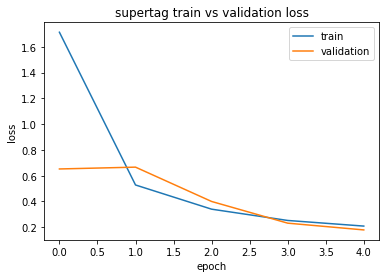

In [23]:
plt.plot(history.history['time_distributed_9_loss'])
plt.plot(history.history['val_time_distributed_9_loss'])
plt.title('supertag train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

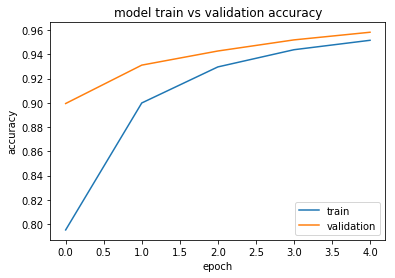

In [24]:
plt.plot(history.history['time_distributed_9_acc'])
plt.plot(history.history['val_time_distributed_9_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [23]:
model.save('elmo_superpostagger.h5')

In [ ]:
model = load_model('elmo_superpostagger.h5')

### Get the output for some of the test data

In [24]:
print(X_test[0])
print(len(X_test[0]))

['Elles', 'se', 'sont', 'fait', 'un', 'nom', ',', 'mais', 'pas', 'un', 'empire', ',', 'comme', 'Nike', 'ou', 'Reebok', '.']
17


In [25]:
small_test = X_test_embedding[0:10]
print(len(small_test)) 
print(small_test)
print(X_test[1])

10
[[[ 0.00300961 -0.27607939 -0.13620102 ...,  0.1755708   0.56884044
    0.54117817]
  [-0.32278445  0.31394929 -0.18110092 ..., -0.12293569 -0.01996567
    0.36818442]
  [-0.1283028   0.37599394  0.09973344 ..., -0.09484682 -0.00469211
    0.10816076]
  ..., 
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]]

 [[-0.00347276 -0.27154061 -0.13722344 ...,  0.1458752   0.40709153
    0.36245313]
  [-0.24611735 -0.20672499 -0.09425887 ..., -0.03341492 -0.26311433
    0.28198725]
  [-0.09962585 -0.10635195  0.16594699 ...,  0.13042311 -0.4032582
    0.06852895]
  ..., 
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.

In [26]:
predict_pos1, predict_pos2, predict_super = model.predict(small_test)

totalp1 = 0
correctp1 = 0
totalp2 = 0
correctp2 = 0
totalsuper = 0
correctsuper = 0

for i in range(len(small_test)):
    for j in range(len(X_test[i])):
        p1 = np.argmax(predict_pos1[i][j])
        p2 = np.argmax(predict_pos2[i][j])
        super = np.argmax(predict_super[i][j])

        totalp1 = totalp1 + 1
        totalp2 = totalp2 + 1
        totalsuper = totalsuper + 1

        if (p1==Y_pos1_test_indices[i][j]):
            correctp1 = correctp1 + 1
        if (p2==Y_pos2_test_indices[i][j]):
            correctp2 = correctp2 + 1
        if (super==Y_super_test_indices[i][j]):
            correctsuper = correctsuper + 1

        print(X_test[i][j] + "|" + index_to_pos1[p1] + "-" + index_to_pos2[p2] + "|" + index_to_super[super], end=" ")
    print('')    
    
print('')
pctp1 = correctp1/totalp1
print('Correct pos1 tags: '+ str(correctp1) + '/' + str(totalp1) + ' = ' + str(pctp1))
pctp2 = correctp1/totalp2
print('Correct pos2 tags: '+ str(correctp2) + '/' + str(totalp2) + ' = ' + str(pctp2))
pctsuper = correctsuper/totalsuper
print('Correct supertags: '+ str(correctsuper) + '/' + str(totalsuper) + ' = ' + str(pctsuper))

Elle|CLS-PRO:PER|np change|V-VER:pres|dr(0,dl(0,np,s),np) aussi|ADV-ADV|dl(1,s,s) son|DET-DET:POS|dr(0,np,n) statut|NC-NOM|n .|PONCT-PUN|dl(0,s,txt) 
Elle|CLS-PRO:PER|np meurt|V-VER:pres|dr(0,dl(0,np,s),np) dans|P-PRP|dr(0,pp,np) le|DET-DET:ART|dr(0,np,n) seul|ADJ-ADJ|dr(0,n,n) vacarme|NC-NOM|n des|P+D-PRP:det|dr(0,dl(0,n,n),n) bouchons|NC-NOM|n qui|PROREL-PRO:REL|dr(0,dl(0,n,n),dl(0,np,s)) sautent|V-VER:pres|dr(0,dl(0,np,s),np) pour|P-PRP|dr(0,dl(0,np,s_inf),dl(0,np,s_inf)) célébrer|VINF-VER:infi|dr(0,dl(0,np,s_inf),np) l'|DET-DET:ART|dr(0,np,n) année|NC-NOM|n nouvelle|ADJ-ADJ|dl(0,n,n) .|PONCT-PUN|dl(0,s,txt) 
La|DET-DET:ART|dr(0,np,n) série|NC-NOM|n que|PROREL-PRO:REL|dr(0,dl(0,n,n),dr(0,s,dia(1,box(1,np)))) les|DET-DET:ART|dr(0,np,n) téléspectateurs|NC-NOM|n peuvent|V-VER:pres|dr(0,dl(0,np,s),dl(0,np,s_inf)) suivre|VINF-VER:infi|dr(0,dl(0,np,s_inf),np) aujourd'hui|ADV-ADV|dl(1,s,s) -|PONCT-PUN|let l'|DET-DET:ART|dr(0,np,n) une|NC-NUM|n des|P+D-PRP:det|dr(0,dl(0,n,n),n) toutes|ADJ-A

### Load best supertagger

In [7]:
model = load_model('best_elmo_superpos.h5')

### Load test data

In [8]:
testf = np.load('test.npz')

X_test = testf['X_test']
X_test_embedding = testf['X_test_embedding']
Y_pos1_test_oh = testf['Y_pos1_test_oh']
Y_pos2_test_oh = testf['Y_pos2_test_oh']
Y_super_test_oh = testf['Y_super_test_oh']

del testf


### Evaluate on full test data

Compute model predictions for part-of-speech tags and supertags

In [10]:
predict_pos1, predict_pos2, predict_super = model.predict(X_test_embedding)

In [12]:

totalp1 = 0
correctp1 = 0
totalp2 = 0
correctp2 = 0
totalsuper = 0
correctsuper = 0

for i in range(len(X_test_embedding)):
    for j in range(len(X_test[i])):
        p1 = np.argmax(predict_pos1[i][j])
        p2 = np.argmax(predict_pos2[i][j])
        super = np.argmax(predict_super[i][j])

        cp1 = np.argmax(Y_pos1_test_oh[i][j])
        cp2 = np.argmax(Y_pos2_test_oh[i][j])
        csuper = np.argmax(Y_super_test_oh[i][j])
        
        totalp1 = totalp1 + 1
        totalp2 = totalp2 + 1
        totalsuper = totalsuper + 1

        if (p1==cp1):
            correctp1 = correctp1 + 1
        if (p2==cp2):
            correctp2 = correctp2 + 1
        if (super==csuper):
            correctsuper = correctsuper + 1
    #print(i, end =' ')
        # print(X_test[i][j] + "|" + index_to_pos1[p1] + "-" + index_to_pos2[p2] + "|" + index_to_super[super], end=" ")
    #print('')    
    
print('= results on test data =')
pctp1 = correctp1/totalp1
print('Correct pos1 tags: '+ str(correctp1) + '/' + str(totalp1) + ' = ' + str(pctp1))
pctp2 = correctp2/totalp2
print('Correct pos2 tags: '+ str(correctp2) + '/' + str(totalp2) + ' = ' + str(pctp2))
pctsuper = correctsuper/totalsuper
print('Correct supertags: '+ str(correctsuper) + '/' + str(totalsuper) + ' = ' + str(pctsuper))

= results on test data =
Correct pos1 tags: 87813/88575 = 0.9913971210838273
Correct pos2 tags: 87895/88575 = 0.99232289020604
Correct supertags: 82536/88575 = 0.9318204911092295


#### Pos1

| epochs | train | dev | test |
|--------|:-----:|:---:|:----:|
| 50     |  99.16     | 99.14    | 99.14 |

#### Pos2

| epochs | train | dev | test |
|--------|:-----:|:---:|:----:|
| 50     |  99.15     | 99.20    | 99.24 |

#### Super

| epochs | train | dev | test |
|--------|:-----:|:---:|:----:|
| 50     |  94.91    | 93.25    | 93.18 |




As a sanity check, test on a part of the training data

In [29]:
X_eval = X_train_embedding[0:2000]

predict_pos1, predict_pos2, predict_super = model.predict(X_eval)

totalp1 = 0
correctp1 = 0
totalp2 = 0
correctp2 = 0
totalsuper = 0
correctsuper = 0

for i in range(len(X_eval)):
    for j in range(len(X_train[i])):
        p1 = np.argmax(predict_pos1[i][j])
        p2 = np.argmax(predict_pos2[i][j])
        super = np.argmax(predict_super[i][j])

        totalp1 = totalp1 + 1
        totalp2 = totalp2 + 1
        totalsuper = totalsuper + 1

        if (p1==Y_pos1_train_indices[i][j]):
            correctp1 = correctp1 + 1
        if (p2==Y_pos2_train_indices[i][j]):
            correctp2 = correctp2 + 1
        if (super==Y_super_train_indices[i][j]):
            correctsuper = correctsuper + 1
    #print(i, end =' ')
        # print(X_test[i][j] + "|" + index_to_pos1[p1] + "-" + index_to_pos2[p2] + "|" + index_to_super[super], end=" ")
    #print('')    
    
print('= results on test data =')
pctp1 = correctp1/totalp1
print('Correct pos1 tags: '+ str(correctp1) + '/' + str(totalp1) + ' = ' + str(pctp1))
pctp2 = correctp2/totalp2
print('Correct pos2 tags: '+ str(correctp2) + '/' + str(totalp2) + ' = ' + str(pctp2))
pctsuper = correctsuper/totalsuper
print('Correct supertags: '+ str(correctsuper) + '/' + str(totalsuper) + ' = ' + str(pctsuper))

= results on test data =
Correct pos1 tags: 47583/48449 = 0.9821255340667506
Correct pos2 tags: 47753/48449 = 0.9856343784185432
Correct supertags: 41073/48449 = 0.8477574356539866


### Try on your own list of sentences (as lists)

In [31]:
sent_list = [['Jean', 'aime', 'Marie', 'et', 'Pierre', 'Suzanne'],['Jean', 'se', 'demande', 'comment', 'aider', 'Marie']]

In [32]:
sl_emb = e.sents2elmo(sent_list)

2019-06-06 19:21:12,048 INFO: 1 batches, avg len: 8.0


In [42]:
print(len(sl_emb))
print(np.shape(sl_emb[0]))
for k in range(6):
    print(k)
print(sent_list[0][5])
print(sl_emb[0][5])

2
(6, 1024)
0
1
2
3
4
5
Suzanne
[ 0.10293496 -0.3746914   0.14215054 ..., -0.02903659 -0.02374802
 -0.22927451]


In [46]:
ll = len(sl_emb)

Xsents = np.zeros((ll,maxLen,1024))
for i in range(ll):
    sl = len(sent_list[i])
    print(sl)
    for j in range(sl):
        Xsents[i][j]= sl_emb[i][j]
print(np.shape(Xsents))

6
6
(2, 266, 1024)


In [53]:
predict_pos1, predict_pos2, predict_super = model.predict(Xsents)

for i in range(len(sent_list)):
    for j in range(len(sent_list[i])):
        p1 = np.argmax(predict_pos1[i][j])
        p2 = np.argmax(predict_pos2[i][j])
        super = np.argmax(predict_super[i][j])
        print(sent_list[i][j] + "|" + index_to_pos1[p1] + "-" + index_to_pos2[p2] + "|" + index_to_super[super], end=" ")
    print('')
    
print('')

Jean|NPP-NAM|np aime|V-VER:pres|dr(0,dl(0,np,s),np) Marie|NPP-NAM|np et|CC-KON|dr(0,dl(0,np,np),np) Pierre|NPP-NAM|dr(0,np,np) Suzanne|NPP-NAM|np 
Jean|NPP-NAM|np se|CLR-PRO:PER|cl_r demande|V-VER:pres|dr(0,dl(0,cl_r,dl(0,np,s)),dl(0,np,s_inf)) comment|ADVWH-ADV|dr(0,s_whq,dl(0,np,s_inf)) aider|VINF-VER:infi|dr(0,dr(0,dl(0,np,s_inf),pp_a),np) Marie|NPP-NAM|np 

Correct pos1 tags: 0/12 = 0.0
